**main script**
<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/medicinely/fwi/blob/main/testcode.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>

In [ ]:
# !git clone https://github.com/medicinely/fwi.git
# %cd fwi

# Deterministic Full Waveform Inversion

In [1]:
from IPython.display import clear_output
import time
import numpy as np
import scipy as sc
import scipy.sparse as sp
import matplotlib.pyplot as plt
labelsize = 16

from scipy.optimize import minimize
from func.propagation_matrix import prop2d, defmodel, J, second_order_derivative

import tensorflow as tf
import tensorflow_probability as tfp
from sklearn.metrics.pairwise import pairwise_distances
from sksparse.cholmod import cholesky
print('GPU:',tf.config.list_physical_devices('GPU'))

import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

# import cupy as cp
precision = np.float32
device = 'cpu'

## Tensorflow mapping function
# def f_tf(u, vmin=2000, vmax=3000):
#     cdf = tfp.distributions.Normal(loc=0, scale=1).cdf(u)
#     # cdf =  tf.math.exp(-tf.math.square(u_tf)) / tf.math.sqrt(2.0 * np.pi)
#     v = (vmax - vmin) * cdf + vmin
#     return v

# Mapping function from u to v
def f(u, vmin=2000, vmax=3000):
    # CDF of gaussian
    cdf = sc.stats.norm.cdf(u.flatten(), loc=0, scale=1)
    v = (vmax-vmin) * cdf + vmin
    return v

# def f(u, a=2000, b=3000):
# 	'''
# 	Reparametrization mapping function from u -> v
# 	Unconstrained parameter -> Physical parameter space
# 	'''
# 	v = a+(b-a)/(1+np.exp(-u))

# 	return v


def f_inv(v, a=2000, b=3000):
	'''Inverse of the mapping function f^-1'''
	u = np.log(v-a) - np.log(b-v)

	return u


# Define cost function
def loglik_fn(u,d_obs,wsrc,zxsrc,zxrec,at,az,ax,next,device,alpha):
	# J: Prior part
	v = f(u)
	log_likelihood = -J(v,d_obs,wsrc,zxsrc,zxrec,at,az,ax,next,device) / alpha
 
	return tf.cast(log_likelihood, tf.float32)


# Calculate gradient with Adjoint state method
def dloglik_du_fn(u,d_obs,wsrc,zxsrc,zxrec,at,az,ax,next,device,alpha):
	"""
	Calculate gradiant using adjoint state method
	"""
	# Calculate forward propagated p_fwd(z,x,t) (to update)
	v = f(u)
	nz, nx, nt = len(az), len(ax), len(at)
	if v.ndim == 1: v = np.reshape(v,(nz,nx))
	p_fwd, d = prop2d(wsrc,zxsrc,zxrec,v,at,az,ax,next,device)
	residual = d - d_obs # residual shape (n_rec, nt) - residual.shape=(5,801)
	# Calculate back propagated p_back(z,x,t)
	p_back, _ = prop2d(np.flip(residual,axis=1),zxrec,zxsrc,v,at,az,ax,next,device)
	p_back = np.flip(p_back,axis=2)
	# Calculate second order time derivative of p_fwd(z,x,t)
	p_dt_dt = second_order_derivative(p_fwd, at, az, ax)
	# Calculate gradiant
	dJ_dv = 2/v**3  * np.sum(p_back * p_dt_dt, axis=2) # G.shape = (201,201)
	dloglik_dv = -dJ_dv / alpha
	dv_du = sc.misc.derivative(f,u)

	return tf.cast(dloglik_dv.flatten() * dv_du.flatten(), tf.float32)


def dlog_prob_du_fn(u,d_obs,wsrc,zxsrc,zxrec,at,az,ax,next,device,alpha):
	"""
	Calculate gradiant using adjoint state method
	"""
	dloglik_du = dloglik_du_fn(u,d_obs,wsrc,zxsrc,zxrec,at,az,ax,next,device,alpha)
	dlog_prior_du = -Q.dot(u.flatten())

	return dloglik_du + dlog_prior_du


def receiver_position(setup):
  
  if setup==1:
    # Setup 1
    zxrec1 = np.vstack((np.full(len(receivers_width), zxsrc[0]), receivers_width)) # Top
    zxrec2 = np.vstack((np.full(len(receivers_width), nz-zxsrc[0]-1), receivers_width)) # Bottom
    zxrec3 = np.vstack((receivers_height, np.full(len(receivers_height), zxsrc[0]))) # Left
    zxrec4 = np.vstack((receivers_height, np.full(len(receivers_height), nx-zxsrc[0]-1))) # Right
    zxrec = np.hstack((zxrec1,zxrec2,zxrec3,zxrec4))

  if setup==2:
    # Setup 2
    zxrec1 = np.vstack((np.full(nrec, zxsrc[0]), receivers_width)) # Top
    zxrec2 = np.vstack((np.full(nrec, nz-zxsrc[0]-1)//2, receivers_width)) # Bottom
    zxrec3 = np.vstack((receivers_width[:len(receivers_width)//2], np.full(nrec, zxsrc[0])[:len(receivers_width)//2])) # Half Left
    zxrec4 = np.vstack((receivers_width[:len(receivers_width)//2], np.full(nrec, nz-zxsrc[0]-1)[:len(receivers_width)//2])) # Half Right
    zxrec = np.hstack((zxrec1,zxrec2,zxrec3,zxrec4))

  if setup==3:
    # Setup 3
    zxrec1 = np.vstack((np.full(nrec, nz-zxsrc[0]-1)//2, receivers_width)) # Top
    zxrec2 = np.vstack((np.full(nrec, nz-zxsrc[0]-1), receivers_width)) # Bottom
    zxrec3 = np.vstack((receivers_width[len(receivers_width)//2:], np.full(nrec, zxsrc[0])[len(receivers_width)//2:])) # Half Left
    zxrec4 = np.vstack((receivers_width[len(receivers_width)//2:], np.full(nrec, nz-zxsrc[0]-1)[len(receivers_width)//2:])) # Half Right
    zxrec = np.hstack((zxrec1,zxrec2,zxrec3,zxrec4))

  if setup==4:
    # Setup 4
    zxrec1 = np.vstack((np.full(nrec, zxsrc[0])[:len(receivers_width)//2], receivers_width[:len(receivers_width)//2])) # Top
    zxrec2 = np.vstack((np.full(nrec, nz-zxsrc[0]-1)[:len(receivers_width)//2], receivers_width[:len(receivers_width)//2])) # Bottom
    zxrec3 = np.vstack((receivers_width, np.full(nrec, zxsrc[0]))) # Left
    zxrec4 = np.vstack((receivers_width, np.full(nrec, nz-zxsrc[0]-1)//2)) # Right
    zxrec = np.hstack((zxrec1,zxrec2,zxrec3,zxrec4))

  zxrec = np.unique(zxrec,axis=1)

  return zxrec


def sample_from_Qmat(Qmat, num_samples):

  factor = cholesky(Qmat)
  # Generate independent standard normal random variables
  u = np.random.standard_normal((Qmat.shape[0], num_samples))
  # Apply Cholesky factorization operations and permutation
  samples = factor.apply_Pt(factor.solve_DLt(u))
  
  return np.swapaxes(samples,0,1)


2023-06-06 00:07:17.649883: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-06 00:07:18.024634: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-06 00:07:18.976140: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2023-06-06 00:07:20.685788: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-06 00:07:20.857870: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-06 00:07:20.857912: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


## Forward modeling

### 29x29 model

dz,dx,dt (m): 8.0 8.0 0.001697056274847714
Model dimension [nz,nx,nt]:  29 29 235
Number of receivers: 80


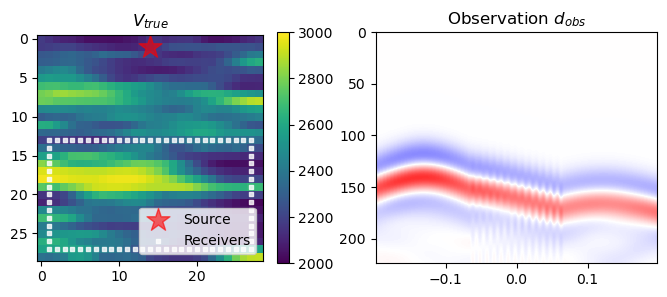

In [4]:
# Model size (nz,nx) = (29,29)
import pickle
# load data
filename = './data/u_29'
infile = open(filename, 'rb')
u_ref = pickle.load(infile)
infile.close()

filename = './data/Q_29'
infile = open(filename, 'rb')
Q = pickle.load(infile)
infile.close()

# Initialize the model axis az, ax, at
nz,nx,nt = 29,29,235
vmin,vmax=2000,3000
izsrc, ixsrc = [1], [nx//2]
next = 10

# v_ref = gaussian2d(ranges=[20,5],variance=50,nx=[nz,nx],param=1,mean=2500)
# u_ref, Q = gaussian2d(ranges = [20,5],param=1,nx=[nz,nx],variance=1,mean=0)
u_ref = u_ref.flatten()
v_ref = f(u_ref)

az, ax, at, next, wsrc, zxsrc = defmodel(
                      vmin=vmin, vmax=vmax, fmax=25, # key parameters
                      nz=nz, nx=nx, nt=nt, # number of indices
                      izsrc=izsrc, ixsrc=ixsrc,  # define source coordinates z, x
                      ext=next)  
dz,dx,dt = az[1]-az[0], ax[1]-ax[0], at[1]-at[0]
# check_model(v=v_ref, vmin=vmin, vmax=vmax)
# Set receiver z and x coordinates
interv = 1 # interval between receivers
receivers_width = np.append(np.arange(zxsrc[1][0],0,-interv)[::-1][:-1], #left
							np.arange(zxsrc[1][0],nx-1,interv)) #right
nrec = len(receivers_width)
zxrec = receiver_position(3)
print("Number of receivers:", len(zxrec.flatten())//2)
# d_obs = simulate_obs(f(u_ref).resh, wsrc, zxsrc, at, az, ax, next, zxrec)
p = prop2d(wsrc,zxsrc,v_ref.reshape(nz,nx),at,az,ax,next,device)
d_obs = p[zxrec[0], zxrec[1], :]

plt.figure(figsize=(8,3))
plt.subplot(1,2,1) 
plt.imshow(v_ref.reshape((nz,nx)),vmin=2000,vmax=3000)
plt.colorbar()
plt.scatter(zxsrc[1,:],zxsrc[0,:],marker='*',color='r',s=300,alpha=0.6,label="Source")
plt.scatter(zxrec[1,:],zxrec[0,:],marker='s',color='w',s=5,alpha=0.8,label="Receivers")
plt.legend(loc='lower right')
plt.title("$V_{true}$")
plt.subplot(1,2,2)
plt.imshow(d_obs.T,cmap='bwr',vmin=-10,vmax=10,extent=[at[0], at[-1], az[-1], az[0]], aspect='auto')
plt.title("Observation $d_{obs}$")
plt.show()

### 200x200 model

Min velocity: 2006.27  Max velocity 2998.51
dz,dx,dt (m): 8.0 8.0 0.001697056274847714
Model dimension [nz,nx,nt]:  200 200 800


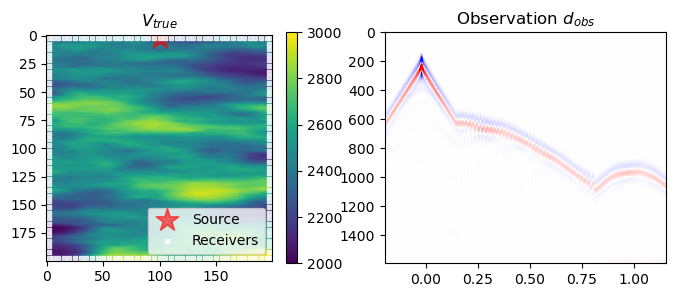

In [2]:
# Model size (nz,nx) = (200,200)

import pickle
# load data
filename = './data/u_200'
infile = open(filename, 'rb')
u_ref = pickle.load(infile)
infile.close()

filename = './data/Q_200'
infile = open(filename, 'rb')
Q = pickle.load(infile).astype('float32')
Q.astype('float32')
infile.close()

# Initialize the model axis az, ax, at
nz,nx,nt = 200,200,800
vmin,vmax = 2000,3000
izsrc, ixsrc = [nz//100], [nx//2]
next = 100

# u_ref, Q = gaussian2d(ranges = [100,20],param=1,nx=[nz,nx],variance=1,mean=0)
v_ref = f(u_ref)
print("Min velocity: %.2f " % v_ref.min()+" Max velocity %.2f" % v_ref.max())

az, ax, at, next, wsrc, zxsrc = defmodel(
                      vmin=vmin, vmax=vmax, fmax=25, # key parameters
                      nz=nz, nx=nx, nt=nt, # number of indices
                      izsrc=izsrc, ixsrc=ixsrc,  # define source coordinates z, x
                      ext=next)  
dz,dx,dt = az[1]-az[0],ax[1]-ax[0],at[1]-at[0]
# check_model(v=v_ref, vmin=vmin, vmax=vmax)
# Set receiver z and x coordinates
interv = 5 # interval between receivers
receivers_width = np.append(np.arange(zxsrc[1][0],0,-interv)[::-1][:-1], #left
							np.arange(zxsrc[1][0],nx,interv)) #right
receivers_height = np.arange(izsrc[0],nz-izsrc[0],interv) # down
zxrec = receiver_position(1)

p, d_obs = prop2d(wsrc,zxsrc,zxrec,v_ref.reshape(nz,nx),at,az,ax,next,device)

plt.figure(figsize=(8,3))
plt.subplot(1,2,1) 
plt.imshow(v_ref.reshape((nz,nx)),vmin=2000,vmax=3000)
plt.colorbar()
plt.scatter(zxsrc[1,:],zxsrc[0,:],marker='*',color='r',s=300,alpha=0.6,label="Source")
plt.scatter(zxrec[1,:],zxrec[0,:],marker='s',color='w',s=5,alpha=0.8,label="Receivers")
plt.legend(loc='lower right')
plt.title("$V_{true}$")
plt.subplot(1,2,2)
plt.imshow(d_obs.T,cmap='bwr',vmin=-10,vmax=10,extent=[at[0], at[-1], az[-1], az[0]], aspect='auto')
plt.title("Observation $d_{obs}$")
plt.show()

## Inversion with prior regularization term

In [ ]:
# Define cost function
def objective_fwi_prior(u,d_obs,wsrc,zxsrc,zxrec,at,az,ax,next,device,alpha):
	# J: Prior part
	v = f(u)
	loss_J = J(v,d_obs,wsrc,zxsrc,zxrec,at,az,ax,next,device) / alpha
	print("Loss (J) = %.4f " % loss_J, end='')
	# Q: Likelihood part
	u = u.flatten()
	penalty = .5 * u.T.dot(Q.toarray()).dot(u)
	print("Penalty term = %.4f " % penalty, end='')
	# Total loss
	loss = loss_J + penalty
	print("Total loss = %.4f " % loss)
	# Save history
	global current_loss
	current_loss = np.array([loss,loss_J,penalty])

	return loss

# Calculate gradient with Adjoint state method
def gradiant_fwi_prior(u,d_obs,wsrc,zxsrc,zxrec,at,az,ax,next,device,alpha):
	"""
	Calculate gradiant using adjoint state method
	"""
	# Calculate forward propagated p_fwd(z,x,t) (to update)
	v = f(u)
	nz, nx, nt = len(az), len(ax), len(at)
	if v.ndim == 1: v = np.reshape(v,(nz,nx))
	p_fwd, d = prop2d(wsrc,zxsrc,zxrec,v,at,az,ax,next,device)
	receiver_depth = zxrec[0]
	residual = d - d_obs # residual shape (n_rec, nt) - residual.shape=(5,801)
	# Calculate back propagated p_back(z,x,t)
	p_back, _ = prop2d(np.flip(residual,axis=1),zxrec,zxsrc,v,at,az,ax,next,device)
	p_back = np.flip(p_back,axis=2)
	# Calculate second order time derivative of p_fwd(z,x,t)
	p_dt_dt = second_order_derivative(p_fwd, at, az, ax)
	# Calculate gradiant
	G = 2/v**3  * np.sum(p_back * p_dt_dt, axis=2) # G.shape = (201,201)

	return G.flatten()*sc.misc.derivative(f,u).flatten()/ alpha + Q.dot(u.flatten())

# Record loss history over each iterations
def callback(xk):
	global loss_tracker
	loss_tracker = np.vstack([loss_tracker,current_loss])
	
# minimize cost function
start = time.time()
u_init = np.zeros([nz*nx])   # Set initial velocity guess (u=0 -> v=2500)
v_init = f(u_init)   # Initial v
loss_tracker = np.empty((0,3))

std_noise = 0.5 # define the noise level
alpha = std_noise**2 # Regularization parameter/weight (Variance of observation noise)

resi = minimize(fun = objective_fwi_prior, 
               x0 = u_init, 
               args = (d_obs,wsrc,zxsrc,zxrec,at,az,ax,next,device,alpha),
               method='L-BFGS-B', 
               # method='Newton-CG',
            #    bounds = np.full((len(u_init.flatten()), 2), (vmin,vmax)),
               jac = gradiant_fwi_prior,
               options = {'disp':True, 'maxiter':150},
               callback=callback
              )
u_fwi = resi.x
print(u_fwi.shape)
print('Total time',time.strftime("%Hh %Mm %Ss", time.gmtime(time.time()-start)))

## FWI result

In [ ]:
# Plot deterministic FWI result and optimization history
v_fwi = f(u_fwi)

plt.figure(figsize=(10,8),dpi=80)
plt.suptitle("$\sigma_{Noise}$ = %.2f  " % std_noise,fontsize=labelsize+8)
# plt.suptitle("$Loss$ = %.2f " % loss_tracker[-1,0],fontsize=labelsize)
plt.subplot(2,2,1) 
plt.imshow(v_ref.reshape(nz,nx),vmin=2000,vmax=3000,extent=[ax[0],ax[-1],az[-1],az[0]], aspect='equal')
cbar = plt.colorbar()
cbar.set_label("Velocity (m/s)")
plt.scatter(zxsrc[1,:]*dz,zxsrc[0,:]*dx,marker='*',color='r',s=300,alpha=0.6,label="Source")
plt.scatter(zxrec[1,:]*dz,zxrec[0,:]*dx,marker='s',color='w',s=5,alpha=0.8,label="Receivers")
plt.legend(loc='lower right')
plt.xlabel('Distance (m)', fontsize=labelsize)
plt.ylabel('Depth (m)', fontsize=labelsize)
plt.title("$V_{True}$",fontsize=labelsize+4)

plt.subplot(2,2,2) 
# plt.imshow(v_init.reshape(nz,nx),vmin=2000,vmax=3000,extent=[ax[0],ax[-1],az[-1],az[0]], aspect='equal')
# cbar = plt.colorbar()
# cbar.set_label("Velocity (m/s)")
# plt.xlabel('Distance (m)', fontsize=labelsize)
# plt.ylabel('Depth (m)', fontsize=labelsize)
# plt.title("$V_{Initial\ Guess}$",fontsize=labelsize+4)
plt.imshow(d_obs.T,cmap='bwr',vmin=-10,vmax=10,extent=[at[0], at[-1], az[-1], az[0]], aspect='auto')
plt.title("Observation $d_{obs}$")

plt.subplot(2,2,3)
plt.imshow(v_fwi.reshape(nz,nx),vmin=2000,vmax=3000,extent=[ax[0],ax[-1],az[-1],az[0]], aspect='equal')
cbar = plt.colorbar()
cbar.set_label("Velocity (m/s)")
plt.xlabel('Distance (m)', fontsize=labelsize)
plt.ylabel('Depth (m)', fontsize=labelsize)
# plt.scatter(zxsrc[1,:],zxsrc[0,:],marker='*',color='r',s=100,alpha=0.6,label="Source")
# plt.scatter(zxrec[1,:],zxrec[0,:],marker='s',color='w',s=0.1,alpha=0.8,label="Receivers")
# plt.legend(loc='lower right')
# plt.title("$V_{Inversion}$ with $\sigma_{Noise}$ = %.2f " % std_noise)
plt.title("$V_{Inversion}$",fontsize=labelsize+4)

plt.subplot(2,2,4)
plt.title("Final cost = %.2f " % loss_tracker[-1,0],fontsize=labelsize)
plt.plot(loss_tracker[:,1],label="Data misfit")
plt.plot(loss_tracker[:,2],label="Regularization penalty")
plt.plot(loss_tracker[:,0],label="Total cost")
plt.xlabel("Iteration",fontsize=labelsize)
plt.ylabel("Cost",fontsize=labelsize)
# plt.xlim(0,150)
# plt.ylim(0,800)
plt.legend(fontsize=labelsize-4)
plt.tight_layout()
plt.show()

# SVGD

In [3]:
from joblib import Parallel, delayed

def display_particles(q_particles, q_mean, q_std_map, save_figure=False):

  vmin, vmax = f(u_ref).min(), f(u_ref).max()

  plt.figure(figsize=(14,8), dpi=300)
  plt.suptitle("$\sigma_{Noise}=$%.2f  " % std_noise + \
              "    $N_{particles}=$"+str(num_particles)+
              "     $h=%.2f$" % h,
              fontsize=labelsize+8)

  plt.subplot(2,3,1)
  plt.imshow(f(u_ref).reshape((nz,nx)),vmin=vmin, vmax=vmax)
  plt.colorbar()
  plt.scatter(zxsrc[1,:],zxsrc[0,:],marker='*',color='r',s=300,alpha=0.6,label="Source")
  plt.scatter(zxrec[1,:],zxrec[0,:],marker='s',color='w',s=5,alpha=0.8,label="Receivers")
  plt.title("Prior sample $f(u_{True} \sim p(u))$", fontsize=16)

  plt.subplot(2,3,2)
  plt.imshow(f(q_mean.numpy()).reshape((nz,nx)),vmin=vmin, vmax=vmax)
  plt.colorbar()
  plt.title("Posterior Mean $f(\mu_{X} \sim q(u))$", fontsize=16)

  plt.subplot(2,3,3)
  # plt.imshow(tf.reshape(tfp.stats.stddev(q_particles),[nz,nx]),cmap='Reds')
  plt.imshow(tf.reshape(q_std_map,[nz,nx]),cmap='Reds')
  plt.colorbar()
  plt.title("Posterior Uncertainties $\sigma_{q}(u)$", fontsize=16)

  plt.subplot(2,3,4)
  # plt.imshow(tf.reshape(p_dist.stddev(),[nz,nx]),cmap='Reds')
  plt.colorbar()
  plt.title("Prior Uncertainties $\sigma_{p}(u)$", fontsize=16)

  plt.subplot(2,3,(5,6))
  plt.plot(misfit_history, label='Data misfit J', lw=3)
  plt.xlim(0, 500*(len(misfit_history)//500+1))
  plt.ylim(bottom=0)
  plt.title("Training history", fontsize=16)
  plt.legend(fontsize=16)

  plt.tight_layout()
  # plt.show()
  if save_figure==True:
    if f'gif_{idx:02d}' not in os.listdir('./img/SVGD/'):
      os.system(f'mkdir ./img/SVGD/gif_{idx:02d}')
    plt.savefig(f'./img/SVGD/gif_{idx:02d}/img_{i}.png', 
                  transparent = False,  
                  facecolor = 'white'
                )
  plt.show()
  plt.close()

def compute_dlog_prob_du_fn(u):
    return dlog_prob_du_fn(u.numpy(),d_obs,*args)
    # return tf.cast(gradiant_fwi_prior(u.numpy(),d_obs,*args), tf.float32)

def compute_parallel(u_samples, num_jobs=4):
    grads_log_prob = Parallel(n_jobs=num_jobs)(delayed(compute_dlog_prob_du_fn)(u_sample) for u_sample in u_samples)
    return grads_log_prob

# Define the TensorFlow variables for the variational posterior particles
num_particles = 4
N = tf.cast(num_particles, dtype=tf.float32)

# Sample from the prior distribution with precision matrix Q to initialize particles
# p_mean = tf.zeros(nz*nx, dtype=tf.float32)
# p_cov = tf.cast(sc.sparse.linalg.inv(Q).toarray(), tf.float32)
# p_dist = tfp.distributions.MultivariateNormalTriL(loc=p_mean, scale_tril=tf.linalg.cholesky(p_cov))
# q_particles = tf.Variable(p_dist.sample(num_particles), dtype=tf.float32)

q_particles = tf.Variable(sample_from_Qmat(Q, num_particles), dtype=tf.float32)

# Set up lists to store progress
misfit_history = []

# optimizer = tf.keras.optimizers.Adam()
optimizer = tf.optimizers.Adagrad()

2023-06-06 00:07:28.089177: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-06 00:07:28.089260: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-06 00:07:28.089278: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-06 00:07:29.616067: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-06-06 00:07:29.616140: I tensorflow/compile

In [4]:
# ===============================================================================================
# Set hyper-parameters
optimizer.learning_rate = 0.1
std_noise = 0.1
args = (wsrc,zxsrc,zxrec,at,az,ax,next,device,std_noise)
print(f"Learning Rate: {optimizer.learning_rate.numpy()}")

# Train the variational posterior using the ELBO objective
num_iters = 1

for i in range(num_iters):
    # Print the iteration number
    print(f"Iteration {i + 1}/{num_iters}", end="    ")

  # with tf.GradientTape() as tape:
  # tape.watch(q_particles)
    # Watch the parameters of the variational posterior
    ## Compute the SVGD kernel matrix and its gradient  Cost: O(n^2)
    with tf.GradientTape() as tape:
      tape.watch(q_particles)
      # Compute pairwise distances between all the current particles
      med = np.median(pairwise_distances(q_particles))
      # h = med**2/np.log(num_particles)  # Set bandwidth parameter h to be med^2 / log(n)
      h = med/np.sqrt(2*np.log(num_particles))

      rbf_kernel = tfp.math.psd_kernels.ExponentiatedQuadratic(length_scale=float(h))
      with tape.stop_recording(): q_particles_ = tf.identity(q_particles)
      svgd_kernel_matrix = rbf_kernel.matrix(q_particles, q_particles_)
      grads_kernal_matrix = tape.gradient(svgd_kernel_matrix, q_particles)
      print(tf.reduce_sum(svgd_kernel_matrix[0,:]).numpy() - 1)

    q_mean = tf.reduce_mean(q_particles, axis=0)
    q_std = tfp.stats.stddev(q_particles)
    # q_std_map = tf.sqrt(tf.reduce_mean(tf.square(q_particles - u_fwi), axis=0))

    misfit = J(f(q_mean.numpy()),d_obs,wsrc,zxsrc,zxrec,at,az,ax,next,device)
    print("J = %.2f" % misfit)
    misfit_history.append(misfit)

    # Compute the log(d_obs|v) log-likelihood and its gradient
    log_likelihoods = []
    grads_log_likelihoods = []
    
    # Calculate the gradient of the log-likelihoods
    grads_log_prob = []
    # for u in q_particles: grads_log_prob.append(compute_dlog_prob_du_fn(u))
    grads_log_prob = compute_parallel(q_particles, 10)

    # Compute the SVGD update for each particle
    update_svgd = (tf.matmul(svgd_kernel_matrix, grads_log_prob) + grads_kernal_matrix) / N
    grads_svgd = - update_svgd
    # Apply the SVGD update to the particles
    optimizer.apply_gradients(zip([grads_svgd], [q_particles]))
    
    clear_output(wait=True)

    p_dist = np.zeros_like(q_mean)
    display_particles(q_particles, q_mean, q_std, save_figure=False)



Learning Rate: 0.10000000149011612
Iteration 1/1    

2023-06-06 00:07:53.144539: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


0.4782700538635254
J = 7352.716712092388
J = 7352.72


2023-06-06 00:07:55.682065: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-06-06 00:07:55.687376: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-06-06 00:07:55.703718: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-06-06 00:07:55.708329: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-06-06 00:08:55.169493: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x5d92b350 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-06-06 00:08:55.169534: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2023-06-06 00:08:55.216369: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUC

InternalError: RET_CHECK failure (tensorflow/compiler/xla/service/gpu/gpu_compiler.cc:618) dnn != nullptr  [Op:__inference__update_step_xla_187]

/tmp/ipykernel_4207/3137952953.py:33: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  plt.colorbar()


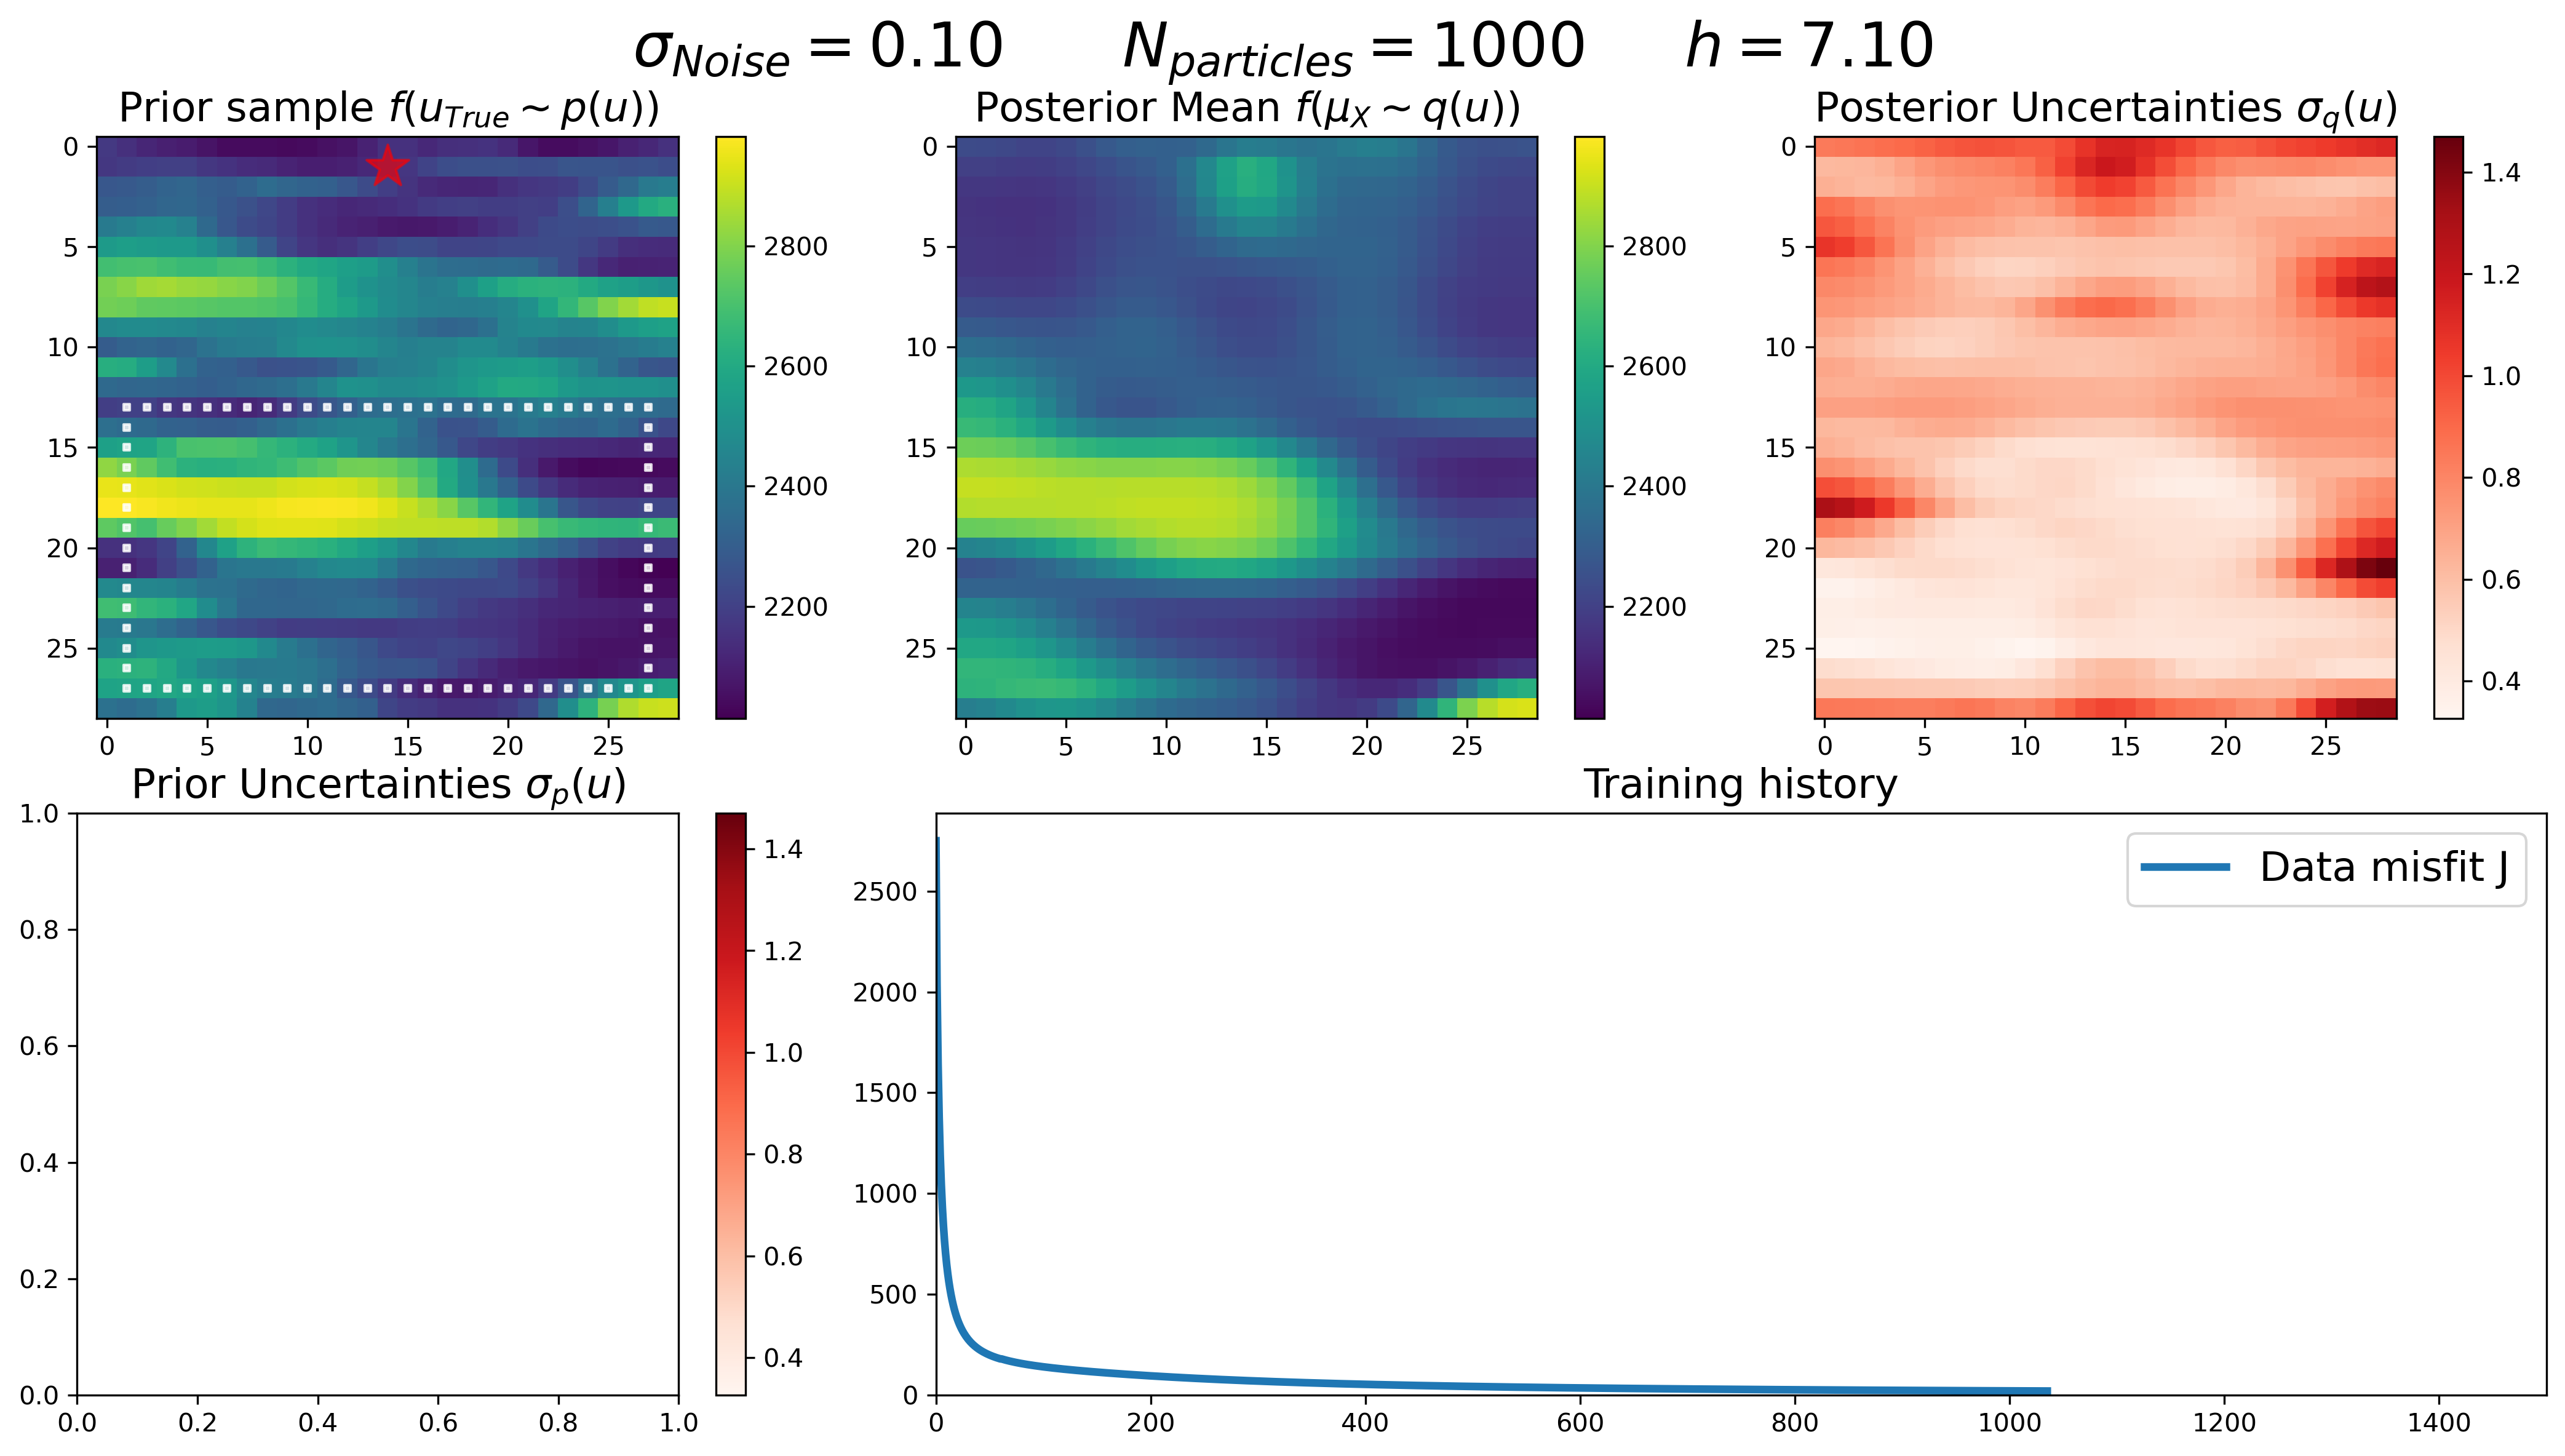

In [55]:
display_particles(q_particles, q_mean, q_std, save_figure=False)

/tmp/ipykernel_4207/455805070.py:33: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  plt.colorbar()


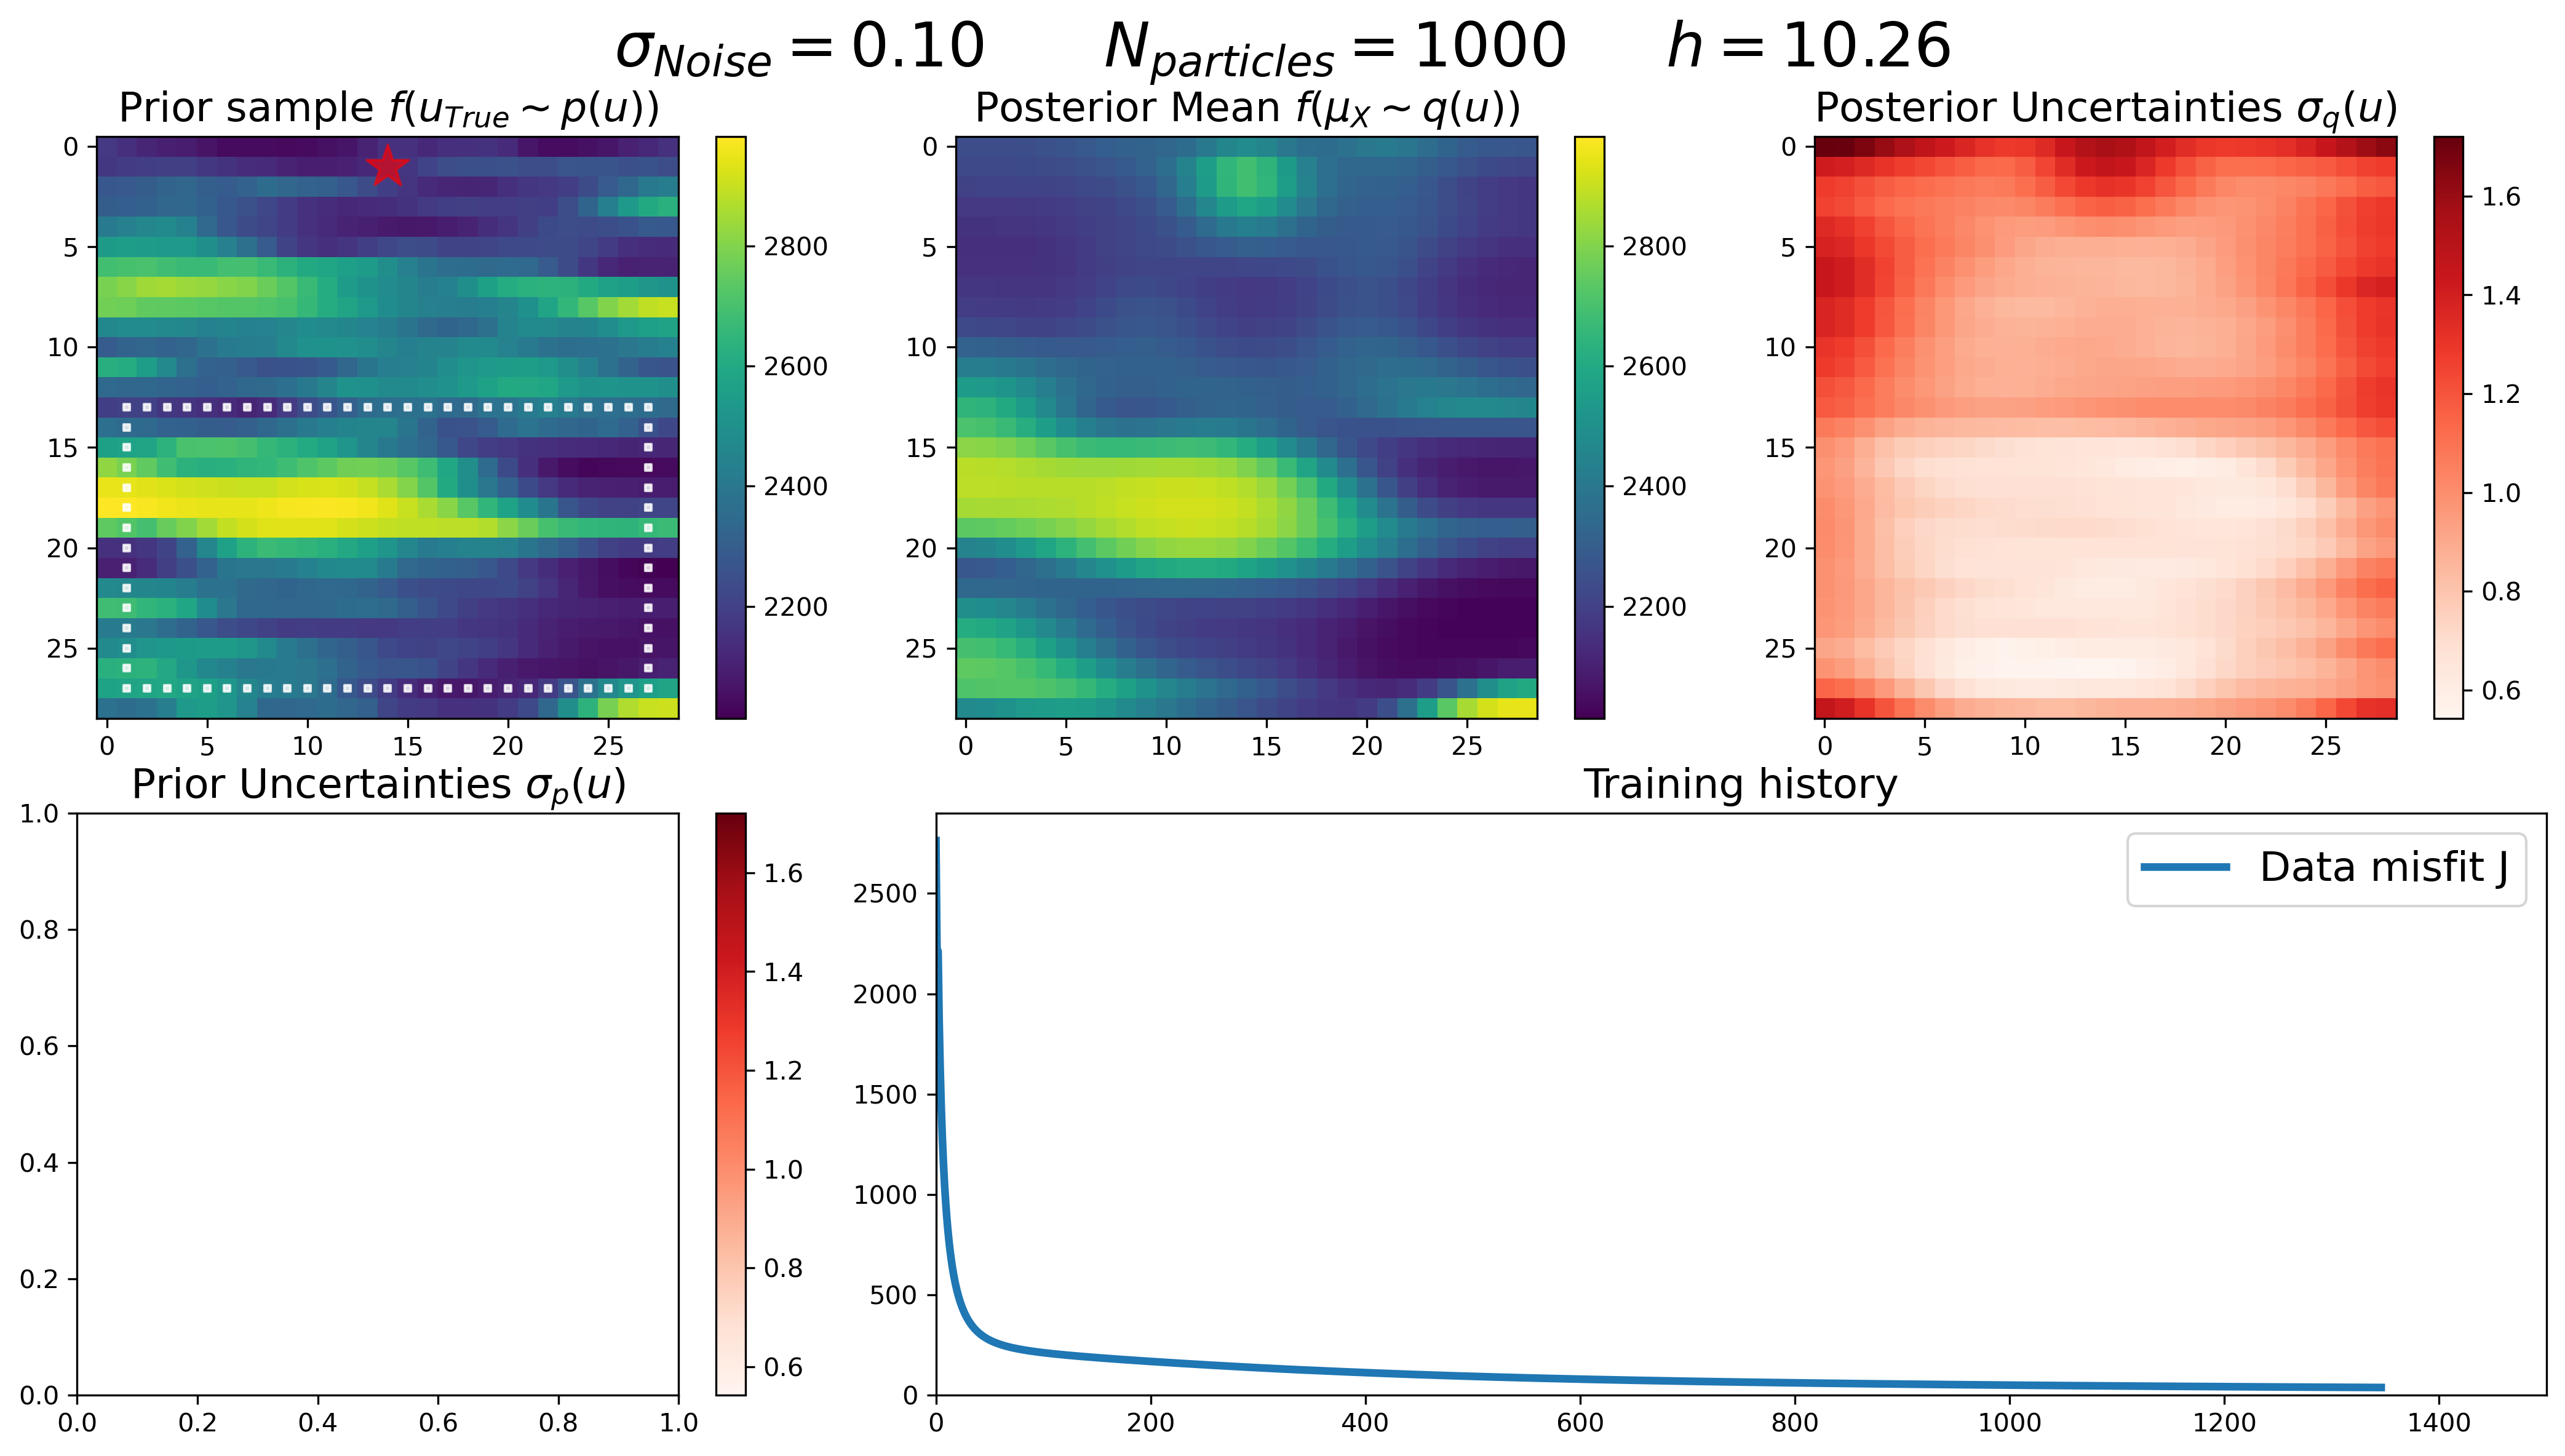

In [27]:
display_particles(q_particles, q_mean, q_std, save_figure=False)